Maybe read this first before you go through the other analysis...

So I took data for this run in 2 shots the first was immediately after mixing and the second was ~3hr later. The first acquisition, 2023-02-07_ATeamCalCurve_1 had the project off center and near the edge of the image. As well the 88uM concentration was very blurry. The second acquisition, 2023-02-07_ATeamCalCurve_2, fixed the centering of the projector, but 88uM is still blurry. I then had to leave to make it to Rob's house. When I came back I measured the thicknesses of each well and made sure all images were focused well. The best set looks like 2023-02-07_ATeamCalCurve_3hrlater_1, I just wish I had taken it immediately! 2023-02-07_ATeamCalCurve_3hrlater_2 is good also, except something went wrong with the projector on 1410uM and the YFP and CFP channels are empty.

TLDR results of this: In general, the immediate aquisitions have higher YFP, lower CFP, and higher ratio intensities than the 3hr later aquisition. This is especially true for the 88uM and the 176uM concentrations.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Numpy imports:
import numpy as np

#Scipy imports
import scipy
from scipy import optimize
from scipy.optimize import curve_fit

# for extracting filenames
import glob

# skimage submodules we need
import skimage.io
import skimage.measure
import skimage.filters
import skimage.exposure
import skimage.morphology
from skimage.registration import phase_cross_correlation

#For identifying aster center
from skimage.filters import threshold_otsu, gaussian
from skimage.measure import regionprops
import cv2

#Matplotlib imports
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable

# # Seaborn imports (stylistic for nice plots)
# import seaborn as sns
# rc={'lines.linewidth': 2, 'axes.labelsize': 14, 'axes.titlesize': 14, \
#     'xtick.labelsize' : 14, 'ytick.labelsize' : 14}
# sns.set(style='ticks', rc=rc)

#for DataFrames
import pandas as pd

#To interact with the operating system
import os

#For status bar 
from tqdm.notebook import tqdm as tqdm

In [3]:
import atp_cal

In [4]:
atp_cal.pboc_style_mpl()

# show images in viridis by default (pboc is fire?)
plt.rcParams['image.cmap'] = 'viridis'

## Compare YFP, CFP, and Ratio values for the different aquisitions 

In [5]:
ATP_conc = [1410, 705, 353, 176, 88, 0]

3hrlater_1

In [6]:
YFP_3hrlater_1 = np.array([1828.21031651, 1670.3378411,  1747.96834427, 1757.37338946, 1352.61812013, 1080.45742096])
 
CFP_3hrlater_1 = np.array([702.46524041,  644.80769427,  724.66613358,  898.71331962, 1096.65695995, 1343.41970346])
 
ratio_3hrlater_1 = np.array([2.60620735, 2.59465684, 2.41534084, 1.95741478, 1.23437199, 0.80474958])

3hrlater_2

In [7]:
YFP_3hrlater_2 = np.array([1648.82000224, 1743.30443086, 1745.37996786, 1346.18514292, 1101.90271321])
 
CFP_3hrlater_2 = np.array([ 633.72320407,  718.92863143,  890.24774855, 1095.22768375, 1374.33681801])
 
ratio_3hrlater_2 = np.array([2.60616069, 2.42804021, 1.96256418, 1.23011659, 0.80221771])

In [11]:
YFP_avg_3hrlater = (YFP_3hrlater_1[1:] + YFP_3hrlater_2)/2
CFP_avg_3hrlater = (CFP_3hrlater_1[1:] + CFP_3hrlater_2)/2
ratio_avg_3hrlater = (ratio_3hrlater_1[1:] + ratio_3hrlater_2)/2

In [33]:
YFP_avg_3hrlater

array([1659.57892167, 1745.63638756, 1751.37667866, 1349.40163153,
       1091.18006709])

_1

In [12]:
YFP_1 = np.array([1702.35616989, 1642.25756658, 1760.55716719, 1762.83976598, 1443.92180823, 1100.90975839])
 
CFP_1 = np.array([ 653.7782499,   628.72118124,  698.78408785,  782.51556159,  891.8238147, 1361.29655726])
 
ratio_1 = np.array([2.60825187, 2.61663248, 2.52324939, 2.25568248, 1.62069077, 0.80925279])

_2

In [13]:
YFP_2 = np.array([1693.99871702, 1674.41408949, 1743.7641869,  1785.9333998,  1452.83275165, 1119.82678766])
 
CFP_2 = np.array([ 658.46987049,  644.89840987,  726.37888825,  807.41468679,  924.13303947, 1408.60802319])
 
ratio_2 = np.array([2.57672164, 2.59993172, 2.40346412, 2.21437922, 1.57421219, 0.79531104])

In [15]:
YFP_avg = (YFP_1 + YFP_2)/2
CFP_avg = (CFP_1 + CFP_2)/2
ratio_avg = (ratio_1 + ratio_2)/2

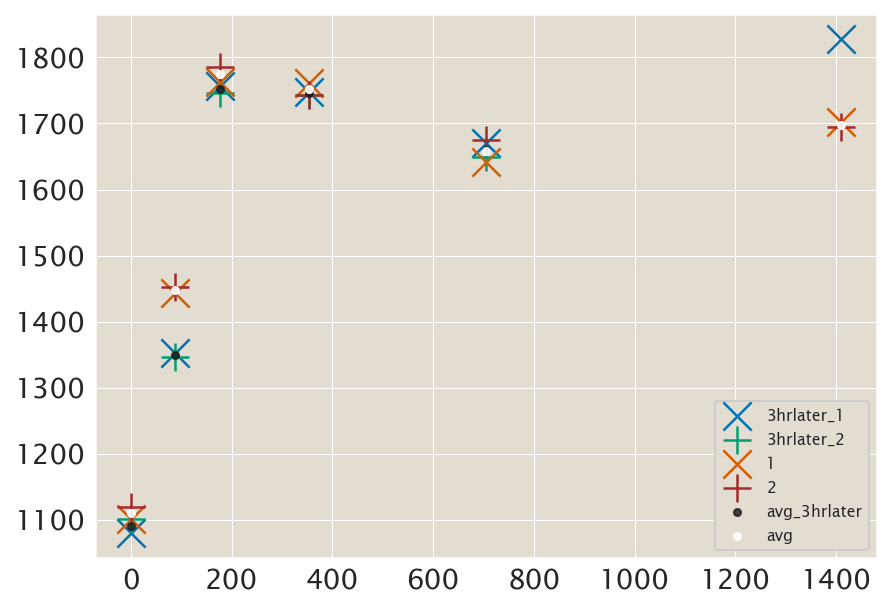

In [37]:
plt.scatter(ATP_conc, YFP_3hrlater_1, label = '3hrlater_1', s =200, marker = 'x', color = 'b')
plt.scatter(ATP_conc[1:], YFP_3hrlater_2, label = '3hrlater_2', s = 200, marker = '+', color = 'g')
plt.scatter(ATP_conc, YFP_1, label = '1', s=200, marker = 'x', color = 'r')
plt.scatter(ATP_conc, YFP_2, label = '2', s=200, marker = '+', color = 'brown')
plt.scatter(ATP_conc[1:], YFP_avg_3hrlater, label = 'avg_3hrlater', s = 50, marker = '.', alpha=0.8, color = 'k')
plt.scatter(ATP_conc, YFP_avg, label = 'avg', s = 50, marker = '.', alpha=0.9, color = 'w')
plt.legend(loc = 'lower right');

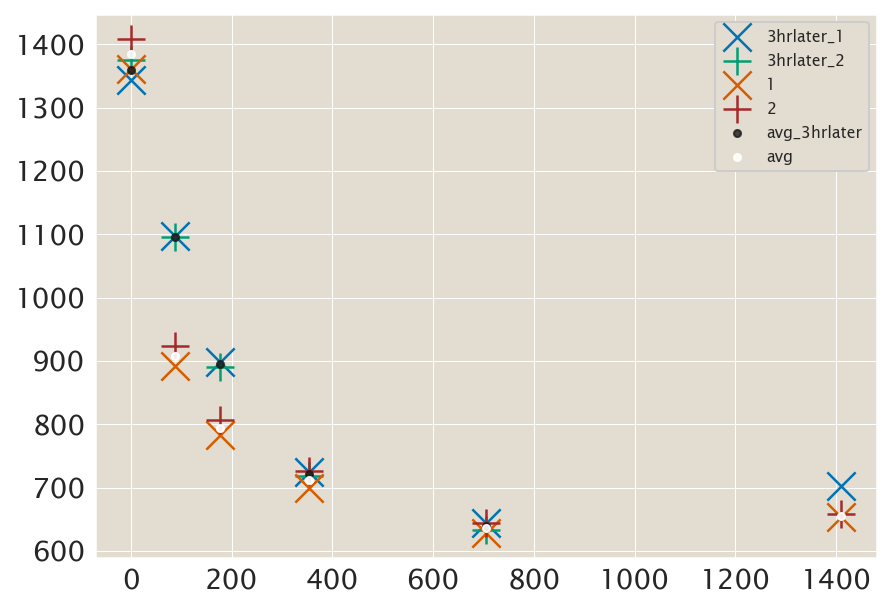

In [38]:
plt.scatter(ATP_conc, CFP_3hrlater_1, label = '3hrlater_1', s =200, marker = 'x', color = 'b')
plt.scatter(ATP_conc[1:], CFP_3hrlater_2, label = '3hrlater_2', s = 200, marker = '+', color = 'g')
plt.scatter(ATP_conc, CFP_1, label = '1', s=200, marker = 'x', color = 'r')
plt.scatter(ATP_conc, CFP_2, label = '2', s=200, marker = '+', color = 'brown')
plt.scatter(ATP_conc[1:], CFP_avg_3hrlater, label = 'avg_3hrlater', s = 50, marker = '.', alpha=0.8, color = 'k')
plt.scatter(ATP_conc, CFP_avg, label = 'avg', s = 50, marker = '.', alpha=0.9, color = 'w')
plt.legend(loc = 'upper right');

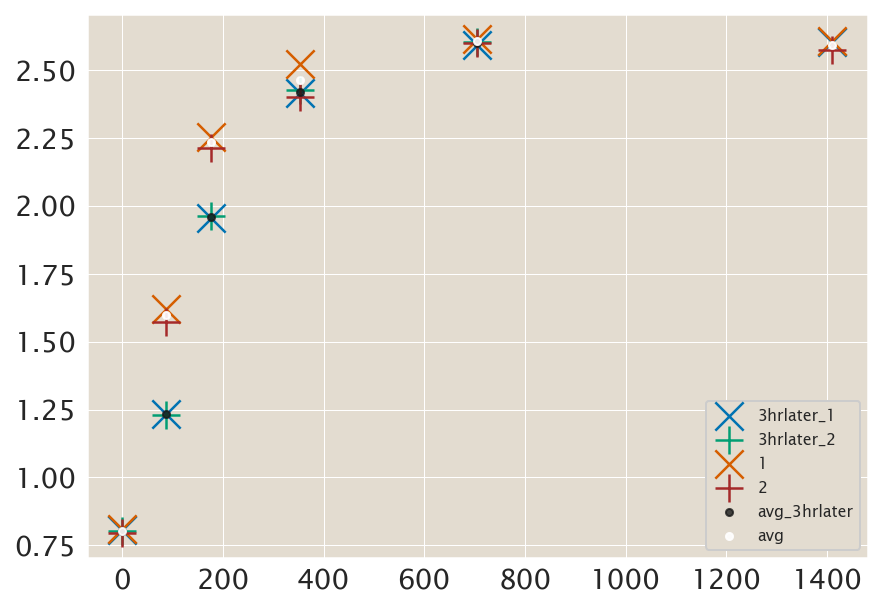

In [39]:
plt.scatter(ATP_conc, ratio_3hrlater_1, label = '3hrlater_1', s =200, marker = 'x', color = 'b')
plt.scatter(ATP_conc[1:], ratio_3hrlater_2, label = '3hrlater_2', s = 200, marker = '+', color = 'g')
plt.scatter(ATP_conc, ratio_1, label = '1', s=200, marker = 'x', color = 'r')
plt.scatter(ATP_conc, ratio_2, label = '2', s=200, marker = '+', color = 'brown')
plt.scatter(ATP_conc[1:], ratio_avg_3hrlater, label = 'avg_3hrlater', s = 50, marker = '.', alpha=0.8, color = 'k')
plt.scatter(ATP_conc, ratio_avg, label = 'avg', s = 50, marker = '.', alpha=0.9, color = 'w')
plt.legend(loc = 'lower right');

In [40]:
#Langmuir equation
def ATeam_Hill(conc, a, b, c, d):
    """
    Given a concentration value, this function returns an intensity value based on the Hill function given
    in Immamura et. al (ATeam paper)
    Parameters
    conc = 1D array of concentrations
    a, b, c, d parameters of the function
    
    Returns
    A 1D array of intensities corresponding to the given concentrations
    """
    
    
    
    return (((b-c)*(conc/a)**d/(1+(conc/a)**d))+c)



#Curve-fit to the Langmuir curve
def ATeam_Hill_curve_fit(conc, calavg, maxconc, p0):
    """
    Performs a curve fitting using scipy.optimize.curve_fit to fit data to a Langmuir curve
    
    Parameters
    conc = 1D array of concentrations
    calavg = 1D array of average intensity values of data
    maxconc = scalar Maximum concentration of data taken
    p0 = 1D list with 4 entries of parameter guesses for a, b, c, and d in the Hill function
    
    Returns
    param = 1D list with fit values of each parameter
    curve = 1D array of intensity values for every concentration in xvals
    xvals = 1D array from 0 to maxconc with step size 1
    """
    
    
    #Curve fits and returns parameter values as well as the covarience
    param, param_cov = curve_fit(ATeam_Hill, 
                                 conc, 
                                 calavg, 
                                 p0, 
                                 bounds = (np.zeros(4), np.ones([4])*np.inf))

    #stores the new function information according to the coefficients given by curve-fit() function 
    xvals=np.linspace(0,maxconc,maxconc)
    curve = ATeam_Hill(xvals, param[0], param[1], param[2], param[3])
    
    return param, curve, xvals

Object `np.pop` not found.


In [54]:
ratio_plot = np.delete(ratio_avg, [4], axis =0)
ATP_plot = np.delete(ATP_conc, [4], axis=0)
params, curve, xvals = ATeam_Hill_curve_fit(ATP_plot[:], ratio_plot[:], ATP_conc[0], [300, 1, 0.5, 7])
roundedparams = []
for i in params:
    roundedparams.append(round(i,2))
roundedparams = np.array(roundedparams)

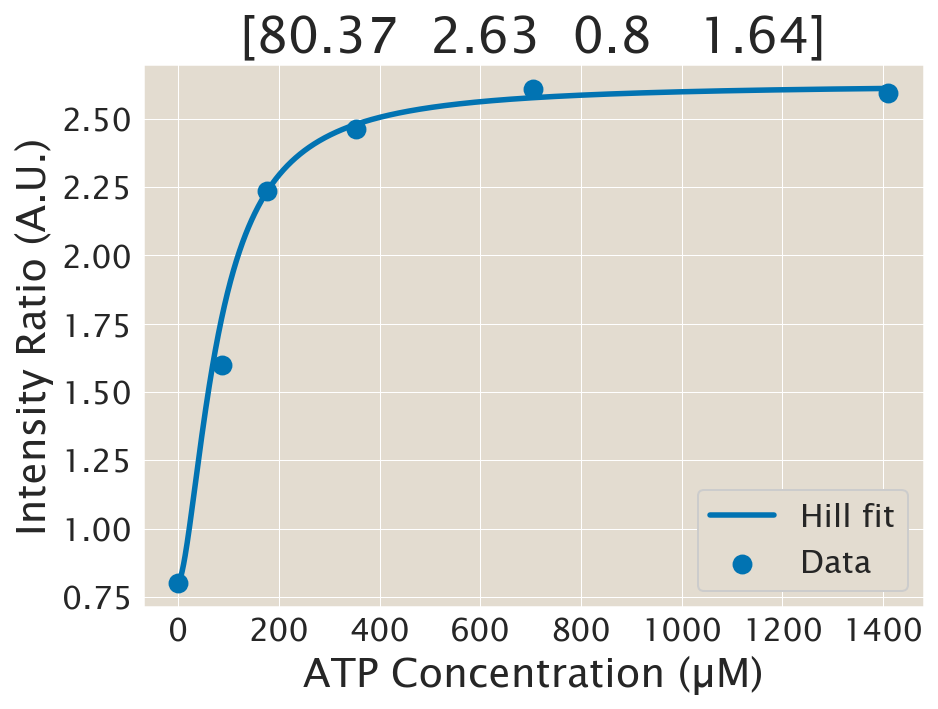

In [55]:
fig, axes = plt.subplots()

plt.scatter(ATP_conc[:], ratio_avg[:], label = 'Data', s=80)
#plt.xscale('log')
plt.plot(xvals, curve, label='Hill fit', linewidth = 2.75)
plt.legend(loc = 'lower right', fontsize = 16)
plt.xlabel('ATP Concentration (µM)', fontsize = 20)
plt.ylabel('Intensity Ratio (A.U.)', fontsize = 20)
plt.title(str(roundedparams), fontsize = 25)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
fig.savefig('2022-06-29_ATeam_Cal_1--Kd=742_Rr=1.49_Rm=0.78_n=2.02.png', dpi=300)